In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, XGBRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer, f1_score

import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Training set is too large for me to run locally
train = pd.read_csv('train.csv')
train = train.sample(25000)
train = train.reset_index()
del train['id']
del train['index']
test = pd.read_csv('test.csv')

# Don't currently need
# combi = pd.concat([train, test])

# For readability
train['comment_text'] = train['comment_text'].str.replace('\n', ' ')
test['comment_text'] = test['comment_text'].str.replace('\n', ' ')

In [3]:
from string import punctuation

def check_for_all_caps(comment):
    comment = comment.translate(str.maketrans("", "", punctuation))
    if comment.isupper():
        return 1
    else:
        return 0

def check_for_some_caps(comment):
    if comment[:20].isupper():
        return 1
    else:
        return 0

train['comment_length'] = train['comment_text'].apply(len)
train['comment_word_count'] = train['comment_text'].apply(lambda x: len(x.split()))
train['comment_exclamation'] = train['comment_text'].apply(lambda x: x.count('!'))
train['comment_exclamation_binary'] = np.where(train['comment_exclamation'] > 0, 1, 0)
train['comment_entirely_caps'] = train['comment_text'].apply(check_for_all_caps)
train['comment_contains_caps'] = train['comment_text'].apply(check_for_some_caps)

In [4]:
x = train['comment_text']

# Y is one-hot encoded, so let's change it for Tfidf
y = np.zeros_like(train['toxic'])

y = np.where(train.toxic == 1, 'toxic', y)
y = np.where(train['severe_toxic'] == 1, 'severe_toxic', y)
y = np.where(train['obscene'] == 1, 'obscene', y)
y = np.where(train['threat'] == 1, 'threat', y)
y = np.where(train['insult'] == 1, 'insult', y)
y = np.where(train['identity_hate'] == 1, 'identity_hate', y)
y = np.where(y == '0', 'ok', y)

# Going to also try making this a binary classification problem
# IMO, all that should matter is whether the comment is ok or not
y_binary = np.where(y == 'ok', 0, 1)

In [5]:
# Original data

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Take the weighted f-1 score as our metric
scorer = make_scorer(f1_score, average='weighted')

pl = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classify', LogisticRegression())
])

params = [{
    'tfidf__max_df': [.02],#np.arange(.02,.21,.02),
    'tfidf__min_df': [50],
    'tfidf__ngram_range': [(1,1)],
    'tfidf__norm': ['l2'],
    'classify__penalty': ['l1', 'l2'],
    'classify__C': [.1, 1, 10],
}]

grid =\
GridSearchCV(pl, cv=3, n_jobs=-1, param_grid=params, scoring='roc_auc')\
.fit(x, y)

model = grid.best_estimator_
print(model)
cv = cross_val_score(model, x, y, cv=4, scoring='roc_auc')

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.02, max_features=None, min_df=50,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Mean score: 0.918481193834
Std Dev:    0.00294406149584


In [6]:
# Binary classification

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pl = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classify', LogisticRegression())
])

params = [{
    'tfidf__max_df': [.02],#np.arange(.02,.21,.02),
    'tfidf__min_df': [50],
    'tfidf__ngram_range': [(1,1)],
    'tfidf__norm': ['l2'],
    'classify__penalty': ['l1', 'l2'],
    'classify__C': [.1, 1, 10],
}]

grid =\
GridSearchCV(pl, cv=3, n_jobs=-1, param_grid=params, scoring=scorer)\
.fit(x, y_binary)

model_binary = grid.best_estimator_
print(model_binary)
cv = cross_val_score(model_binary, x, y_binary, cv=4, scoring=scorer)

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.02, max_features=None, min_df=50,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Mean score: 0.936455629087
Std Dev:    0.00330011391301


In [7]:
tfidf = TfidfVectorizer(min_df=50, max_df=.02, ngram_range=(1,1))

x_all = tfidf.fit_transform(train['comment_text'])
x_all = pd.DataFrame(x_all.todense())

preds = model_binary.predict_proba(x)[:,1]
x_all['toxicity'] = preds

engineered_feats = train[['comment_length','comment_word_count','comment_exclamation',
      'comment_exclamation_binary','comment_entirely_caps','comment_contains_caps']].copy()

x_all = pd.concat([x_all, engineered_feats], axis=1)

In [8]:
# Combined

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pl = Pipeline([
    ('classify', LogisticRegression())
])

params = [{
    'classify__penalty': ['l1', 'l2'],
    'classify__C': [.1, 1, 10],
}]

grid =\
GridSearchCV(pl, cv=3, n_jobs=-1, param_grid=params, scoring=scorer)\
.fit(x_all, y)

model = grid.best_estimator_
print(model)
cv = cross_val_score(model, x_all, y, cv=4, scoring=scorer)

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Pipeline(memory=None,
     steps=[('classify', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Mean score: 0.909271012211
Std Dev:    0.00242273686956


# Visualizing the model's effectiveness

Let's plot the ROC curve for binary classification...

In [9]:
def results_df(label_test, pred_proba, pred, print_report=True):
    '''
    Compares how well the model is identifying people compared
    to random chance.
    '''
    results = pd.DataFrame()

    results['actual'] = label_test
    results['predicted'] = pred_proba
    
    results.sort_values('predicted', ascending=False, inplace=True)
    
    # Counting positive observations
    results['model_count'] = pd.Series.cumsum(results.actual)
    results['percentage'] = 1/len(results)
    results['random_count'] = pd.Series.cumsum(results['percentage']) * np.sum(results['actual'])
    
    # Percentage of the total found
    results['model_select'] = results['model_count']/np.sum(results['actual'])
    results['random_select'] = pd.Series.cumsum(results.percentage)

    del results['percentage']
    
    
    return results

In [10]:
model_binary.fit(x, y_binary)
pred_proba = model_binary.predict_proba(x)[:,1]
pred = model_binary.predict(x)

results = results_df(y_binary, pred_proba, pred)

In [11]:
def plot_curve(df):
    plt.plot(df.random_select, df.model_select, color='red')
    plt.plot(df.random_select, df.random_select, color='blue')

    plt.ylabel('Percent found')
    plt.xlabel('Percent selected')

    plt.ylim(0,1)
    plt.xlim(0,1)

    plt.xticks([0, .25, .5, .75, 1])
    plt.yticks([.1, .2, .3, .4,
                .5, .6, .7, .8, .9, 1])

    from pylab import rcParams
    rcParams['figure.figsize'] = 10, 6

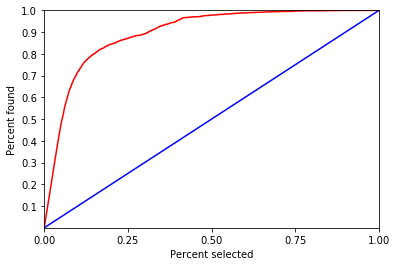

In [12]:
plot_curve(results)

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

def word_probabilities(col, pipeline=pl, min_df=.01):
    words_dict = {}
    bow_transformer = CountVectorizer(min_df=min_df, ngram_range=(1,3))
    bow_transformer.fit(col)

    for word in bow_transformer.vocabulary_.keys():
        prob = pipeline.predict_proba([word])[0][1]
        words_dict[word] = prob
        
    df = pd.DataFrame([words_dict]).T
    df.columns = ['probability']
    df = df.sort_values('probability', ascending=False)
    
    return df

In [14]:
# Generate word list
words = word_probabilities(train['comment_text'], model_binary)

words

,probability
fuck,1.000000
fucking,0.999999
dont,0.382911
big,0.297245
guy,0.272681
deleting,0.227915
hey,0.221895
care,0.220494
site,0.189829
oh,0.183482


In [15]:
# Don't un-comment this unless you want to see the worst of humanity :)

# train['pred'] = pred_proba
# train.sort_values('pred', ascending=False)

# TODO:
    
- Deep learning

In [17]:
x = train.pop('comment_text').values
y = train.values

In [19]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPool1D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

# set parameters:
max_features = 20000
maxlen = 400
embedding_dims = 50

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Fit tokenizer

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x)

xtrain, xval, ytrain, yval = train_test_split(x, y, test_size=.2)

# Tokenize training and validation data
sequences = tokenizer.texts_to_sequences(xtrain)
sequences_test = tokenizer.texts_to_sequences(xval)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
data_test = pad_sequences(sequences_test, maxlen=maxlen)

labels = np.array(ytrain)
labels_test = np.array(yval)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

print('Shape of data tensor:', data_test.shape)
print('Shape of label tensor:', labels_test.shape)

Found 66783 unique tokens.
Shape of data tensor: (20000, 400)
Shape of label tensor: (20000, 6)
Shape of data tensor: (5000, 400)
Shape of label tensor: (5000, 6)


In [20]:
batch_size = 64
epochs = 5
filters = 512
kernel_size = 3
hidden_dims = 250

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_acc', patience=0)

model_cnn = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model_cnn.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model_cnn.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model_cnn.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

model_cnn.add(GlobalMaxPooling1D())

# Fully connected layer
model_cnn.add(Dense(hidden_dims))
model_cnn.add(Dropout(0.2))
model_cnn.add(Activation('relu'))

model_cnn.add(Dense(6))
model_cnn.add(Activation('softmax'))

model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_cnn.fit(data, labels,
          batch_size=batch_size,
          epochs=epochs, callbacks=[es],
          validation_data=(data_test, labels_test))

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 886s - loss: 0.3005 - acc: 0.9905 - val_loss: 0.3189 - val_acc: 0.9938

Let's compare the accuracy to that of XGBoost. Let's run the following code again:

In [6]:
# Training set is too large for me to run locally
train = pd.read_csv('train.csv')
train = train.sample(25000)
train = train.reset_index()
del train['id']
del train['index']
test = pd.read_csv('test.csv')

# Don't currently need
# combi = pd.concat([train, test])

# For readability
train['comment_text'] = train['comment_text'].str.replace('\n', ' ')
test['comment_text'] = test['comment_text'].str.replace('\n', ' ')

x = train['comment_text']

# Y is one-hot encoded, so let's change it for Tfidf
y = np.zeros_like(train['toxic'])

y = np.where(train.toxic == 1, 'toxic', y)
y = np.where(train['severe_toxic'] == 1, 'severe_toxic', y)
y = np.where(train['obscene'] == 1, 'obscene', y)
y = np.where(train['threat'] == 1, 'threat', y)
y = np.where(train['insult'] == 1, 'insult', y)
y = np.where(train['identity_hate'] == 1, 'identity_hate', y)
y = np.where(y == '0', 'ok', y)

# Original data

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Take the weighted f-1 score as our metric
scorer = make_scorer(f1_score, average='weighted')

pl = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classify', LogisticRegression())
])

params = [{
    'tfidf__max_df': [.02],#np.arange(.02,.21,.02),
    'tfidf__min_df': [50],
    'tfidf__ngram_range': [(1,1)],
    'tfidf__norm': ['l2'],
    'classify__penalty': ['l1', 'l2'],
    'classify__C': [.1, 1, 10],
}]

grid =\
GridSearchCV(pl, cv=3, n_jobs=-1, param_grid=params, scoring='accuracy')\
.fit(x, y)

model = grid.best_estimator_
print(model)
cv = cross_val_score(model, x, y, cv=4, scoring='accuracy')

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.02, max_features=None, min_df=50,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Mean score: 0.921119698879
Std Dev:    0.00121134175622


A CNN actually does quite well!